In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os, glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.applications.resnet import ResNet101
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import  classification_report
import pickle

In [4]:
file_path = ("../input/color")

In [24]:
name_class = os.listdir(file_path)
name_class
label_dict = {label: index for index, label in enumerate(name_class)}
print(label_dict)
# JSON 파일로 저장
with open('labels.json', 'wb') as f:
    pickle.dump(label_dict, f)

{'Pepper___Bacterial_spot': 0, 'Pepper___healthy': 1, 'Potato___Early_blight': 2, 'Potato___healthy': 3, 'Potato___Late_blight': 4, 'Tomato___Bacterial_spot': 5, 'Tomato___Early_blight': 6, 'Tomato___healthy': 7, 'Tomato___Late_blight': 8, 'Tomato___Leaf_Mold': 9, 'Tomato___Septoria_leaf_spot': 10, 'Tomato___Spider_mites Two-spotted_spider_mite': 11, 'Tomato___Target_Spot': 12, 'Tomato___Tomato_mosaic_virus': 13, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 14}


In [6]:
filepaths = list(glob.glob(file_path+'/**/*.*'))

In [7]:
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepath = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
data = pd.concat([filepath, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head(5)

,Filepath,Label
0,../input/color\Tomato___Leaf_Mold\fe60a756-114...,Tomato___Leaf_Mold
1,../input/color\Potato___Late_blight\8c3c1c3f-5...,Potato___Late_blight
2,../input/color\Tomato___Leaf_Mold\407519ba-54e...,Tomato___Leaf_Mold
3,../input/color\Tomato___Leaf_Mold\921e0584-a41...,Tomato___Leaf_Mold
4,../input/color\Tomato___Tomato_Yellow_Leaf_Cur...,Tomato___Tomato_Yellow_Leaf_Curl_Virus


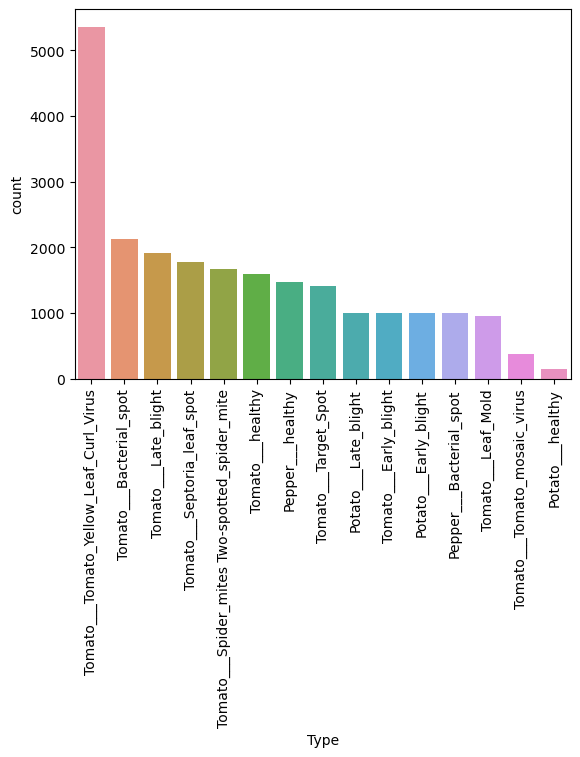

In [8]:
counts = data.Label.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Type')
plt.xticks(rotation=90);

In [9]:
train, test = train_test_split(data, test_size=0.25, random_state=42)

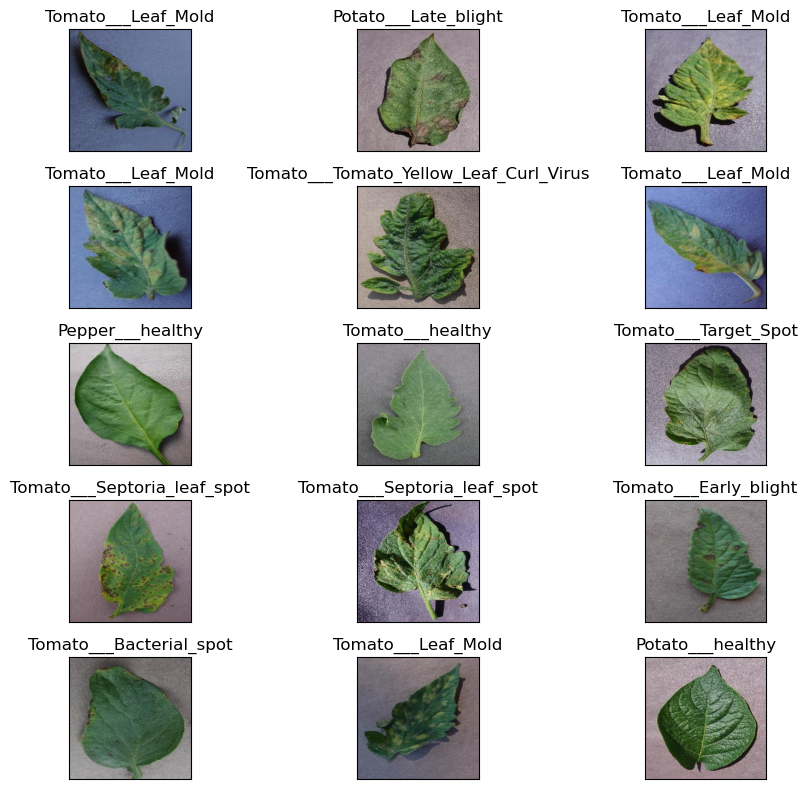

In [10]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10,8), subplot_kw={'xticks':[],'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.Filepath[i]))
    ax.set_title(data.Label[i])
plt.tight_layout()
plt.show()

In [11]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   validation_split=0.2)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [12]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(256,256),
    class_mode='categorical',
    batch_size=12,
    shuffle=True,
    seed=42
)
valid_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(256,256),
    class_mode='categorical',
    batch_size=12,
    shuffle=False,
    seed=42
)
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(256,256),
    class_mode='categorical',
    batch_size=12,
    shuffle=False
)

Found 17090 validated image filenames belonging to 15 classes.
Found 17090 validated image filenames belonging to 15 classes.
Found 5697 validated image filenames belonging to 15 classes.


In [13]:
pretrained_model = ResNet101(
    input_shape=(256,256, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [14]:
inputs = pretrained_model.input

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dense(128, activation='relu')(x)
x = Dense(128, activation='relu')(x)

outputs = Dense(15, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [15]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [16]:
my_callbacks  = [EarlyStopping(monitor='val_accuracy',
                              min_delta=0,
                              patience=2,
                              mode='auto')]

In [17]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=5,
    callbacks=my_callbacks
)

Epoch 1/5


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2430s 2s/step - accuracy: 0.7940 - loss: 0.6447 - val_accuracy: 0.9569 - val_loss: 0.1263
Epoch 2/5
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2821s 2s/step - accuracy: 0.9501 - loss: 0.1475 - val_accuracy: 0.9710 - val_loss: 0.0869
Epoch 3/5
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2121s 1s/step - accuracy: 0.9651 - loss: 0.1029 - val_accuracy: 0.9555 - val_loss: 0.1302
Epoch 4/5
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 1967s 1s/step - accuracy: 0.9690 - loss: 0.0900 - val_accuracy: 0.9892 - val_loss: 0.0353
Epoch 5/5
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 1823s 1s/step - accuracy: 0.9795 - loss: 0.0642 - val_accuracy: 0.9829 - val_loss: 0.0486


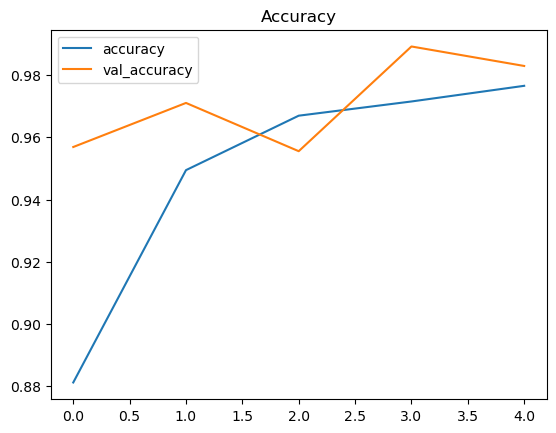

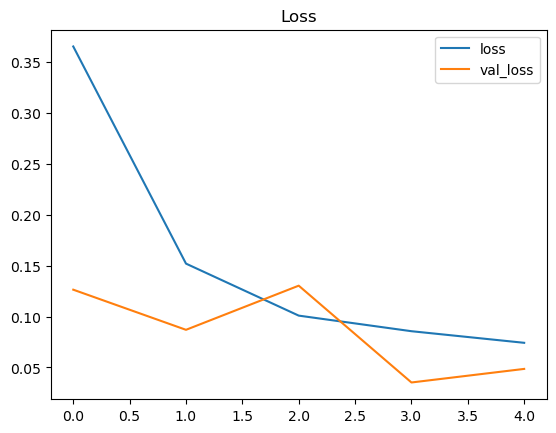

In [18]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [19]:
results = model.evaluate(test_gen, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


    Test Loss: 0.13267
Test Accuracy: 96.16%


In [20]:
# Predict the label of the test_gen
pred = model.predict(test_gen)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

475/475 ━━━━━━━━━━━━━━━━━━━━ 317s 662ms/step


In [21]:
y_test = list(test.Label)
print(classification_report(y_test, pred))

                                               precision    recall  f1-score   support

                      Pepper___Bacterial_spot       1.00      0.98      0.99       260
                             Pepper___healthy       0.99      0.99      0.99       387
                        Potato___Early_blight       0.95      1.00      0.97       239
                         Potato___Late_blight       0.93      0.99      0.96       242
                             Potato___healthy       0.97      0.94      0.96        36
                      Tomato___Bacterial_spot       0.98      0.96      0.97       553
                        Tomato___Early_blight       0.84      0.94      0.89       266
                         Tomato___Late_blight       0.93      0.97      0.95       488
                           Tomato___Leaf_Mold       1.00      0.88      0.94       234
                  Tomato___Septoria_leaf_spot       0.96      0.92      0.94       453
Tomato___Spider_mites Two-spotted_spider_m

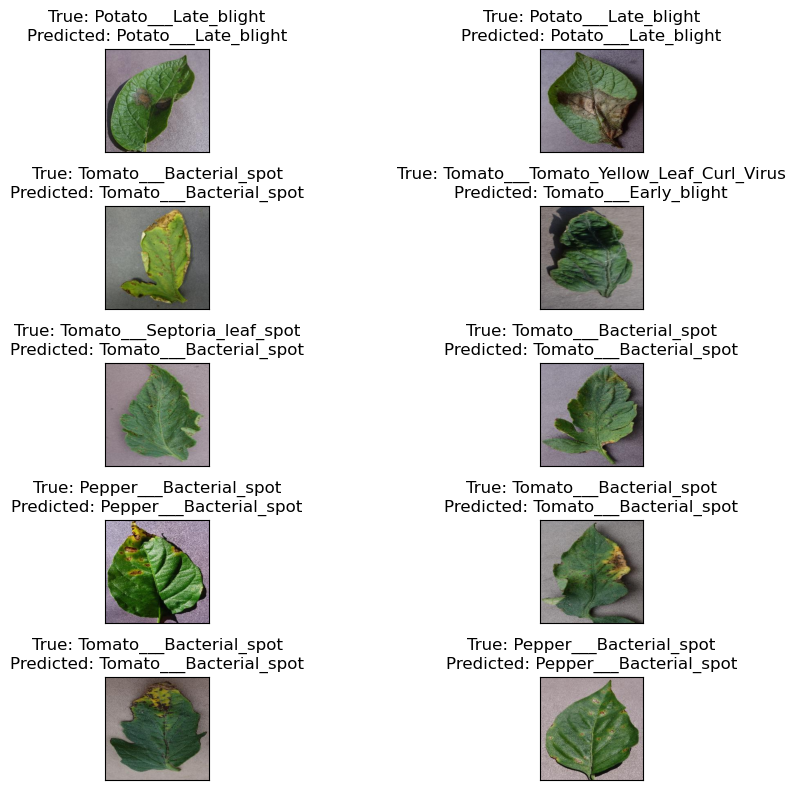

In [22]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test.Filepath.iloc[i]))
    ax.set_title(f"True: {test.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [23]:
model.save('model.h5')